In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(".."))  # Ensure it points to your project root

from van_code.nn import NeuralVANMultilevel_block_wise
from van_code.ising import ising_energy,analytical_solution,local_ising_energy
from van_code.montecarlo import *
from van_code.utils import *
from van_code.obs import Obs
from unzip import file_exists_or_unzip


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    default_dtype_torch=torch.float32
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = torch.device("cpu")
print(f'You are using device={device}.')

You are using device=mps.


-------------
-------------
# Model and parameters
Our multilevel architecture uses different blocks of Autoregressive neural networks which are based on the VAN architecture by [Wu et al. (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.080602).

In [3]:
# This cell defines important parameters for the simulation

Lc=2 # defines the coarser lattice
beta=0.44 # defines the beta value (inverse of the temperature)

# VAN parameters
net_depth = 3
net_width= 16
half_kernel_size =6

# Conditional VAN parameters
# The i-th element of the list correspond to the parameters associated to the i-th block in the multilevel

hidden_size=[[32]] * 10 # Hidden size of each CondVAN
kernel_size=[[5,3]] * 10  # Kernel of CondVAN

#Elia: @Kim questo mi sa che e' da cambiare sistematicamente in "nblocks" 
nlevels = 2 # Defines the number of blocks (upsamling step) in the multilevel. Every block doubles the lattice. Example: if the coarser is 2x2 after 3 levels we have 16x16
hb_last = True # Whether to use heatbath to sample unbiased configuration from the last ARNN

In [4]:
van_hyp={
    'net_depth':net_depth,
    'net_width': net_width,
    'half_kernel_size':half_kernel_size,
    'bias':False,'z2':False,
    'res_block':True,
    'x_hat_clip':False,
    'final_conv':True,
    'epsilon':1.e-8,
    'device':device
}

block_net_hyp={
    'hidden_size':hidden_size,
    'kernel_size':kernel_size,
    'epsilon':1e-7,
    'level':0,
    'device':device
}

In [5]:
# Building the model

#Elia: Not needed in principle but good for the tutorial @Kim
model = NeuralVANMultilevel_block_wise(
    Lc,
    van_hyp,
    block_net_hyp,
    nlevels,
    hb_last,
    ising_energy,
    local_ising_energy,
    beta,
    device
)
Lf = model.Lf
#print(model)

print(f'\n\n=======================================================================================================================================================\n')
print(f'You will start from coarser lattices of shape {Lc}x{Lc} and sample finer lattices of resolution {model.Lf}x{model.Lf} using {nlevels} multilevel steps.')
print(f'\n=======================================================================================================================================================\n')

k_size [[5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3]]
nnot gd 0 [5, 3]
1 [5, 3]
Lf= 8
2 [5, 3]



You will start from coarser lattices of shape 2x2 and sample finer lattices of resolution 8x8 using 2 multilevel steps.




In [6]:
# Define default parameters for optimizer and scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.92, patience=1000, min_lr=1e-07)

# Define additional training parameters. Arbitrary values can be chosen
# the values chosen below are optimized for the purpose of this demo.

bs = 16
nepochs = 500
print_freq = 10
lr = 0.001

In [7]:
# Choose main path to store model and logs
main_path=''+'../data/'

# Creates model identifier with corresponding params
# '/Lf'+'_beta'+'_nblocks'+'_PCNNdepth'+'_width'+'_half_ker'+'_CCNNhs'+'_ks'

model_id = f'{str(model.Lf)}_{str(beta)}_{str(nlevels)}_{str(net_depth)}_{str(net_width)}_{str(half_kernel_size)}_{str(hidden_size[0][0])}_{str(kernel_size[0])}'

lc_path = main_path + 'training/' + model_id
h_path = lc_path + '_history.log' # Path to Training history

## Dict of paths to store different results

res_paths = {
    'weights': main_path+ 'model/'+ model_id +'.pth', # models' weights
    'sim' : main_path + 'results/' + model_id + '_measures.log',  # Simulations logging
    'sim_md' : main_path + 'results/' + model_id + '_measures_modedrop.log',  # Simulations mode dropping
    'cluster' : main_path + 'results/' + model_id + '_measuresCluster.log',  # Simulations
    'dict_hist' : lc_path + '_historyDict.pkl',  # dictionary learning curve
    'mh' : main_path+'results/'+ model_id +'_measuresIMH.log' # neural MCMC sampling results
}


-------------
-------------
# Training

Let's train the model by recursevily training coarser models:

In [8]:
res_paths['weights']= 'pd.pth'

In [9]:
ESS=[]
for i in range(0,nlevels+1):
    if i !=0:
        saved_state_dict = torch.load(res_paths['weights'])
        model.load_state_dict(saved_state_dict, strict=True)
    model = NeuralVANMultilevel_block_wise(
        Lc,
        van_hyp,
        block_net_hyp,
        i,
        hb_last,
        ising_energy,
        local_ising_energy,
        beta,
        device
        )
    
    history=model.train(500, bs, lr, print_freq, h_path, flex_kernel=True, on_file=True)

    torch.save(model.state_dict(),res_paths['weights'])
    ESS+=history['ESS']

k_size [[5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3]]
Lf= 4
0 [5, 3]
Training VAN layers...


/Users/eliacellini/Desktop/scripting/multilevel/van_code/nn.py:713: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # this function will be deprecated. When this happens use function below.
/Users/eliacellini/Desktop/scripting/multilevel/.venv-mlt/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


step: 10, loss: -0.024321317672729492, w_mean: -2.991027355194092, w_var: 4.026379585266113, ess: 0.2309907078742981, free_en: -4.700806140899658, log_prob: -2.7710275650024414
step: 20, loss: -0.05124866962432861, w_mean: -3.207880973815918, w_var: 2.987131357192993, ess: 0.23733673989772797, free_en: -4.673636436462402, log_prob: -2.767881393432617
step: 30, loss: -0.060423970222473145, w_mean: -2.5661628246307373, w_var: 2.2947332859039307, ess: 0.12666556239128113, free_en: -3.775681972503662, log_prob: -2.786162853240967
step: 40, loss: -0.4070560932159424, w_mean: -2.7618484497070312, w_var: 5.7050580978393555, ess: 0.291142076253891, free_en: -4.70198392868042, log_prob: -2.761848211288452
step: 50, loss: -0.32531851530075073, w_mean: -3.1763968467712402, w_var: 2.332972288131714, ess: 0.26753032207489014, free_en: -4.319150924682617, log_prob: -2.7363967895507812
step: 60, loss: -0.5192950367927551, w_mean: -3.169257164001465, w_var: 1.7588355541229248, ess: 0.3181145489215851,

/Users/eliacellini/Desktop/scripting/multilevel/van_code/nn.py:774: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): #this function will be deprecated. If this happens use function below.
/Users/eliacellini/Desktop/scripting/multilevel/.venv-mlt/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


step: 10, loss: -1.143310546875, w_mean: -13.868579864501953, w_var: 0.9043958783149719, ess: 0.29317882657051086, free_en: -14.415142059326172, log_prob: -9.46858024597168
step: 20, loss: -2.013187885284424, w_mean: -13.891091346740723, w_var: 2.0335302352905273, ess: 0.09021517634391785, free_en: -15.719757080078125, log_prob: -9.381091117858887
step: 30, loss: -2.162574291229248, w_mean: -14.662516593933105, w_var: 1.6866899728775024, ess: 0.21063056588172913, free_en: -15.600448608398438, log_prob: -8.39251708984375
step: 40, loss: -2.4868741035461426, w_mean: -14.457378387451172, w_var: 1.7641164064407349, ess: 0.2528989315032959, free_en: -15.308717727661133, log_prob: -8.957377433776855
step: 50, loss: -0.5290002822875977, w_mean: -14.554505348205566, w_var: 0.9293930530548096, ess: 0.299626886844635, free_en: -15.140966415405273, log_prob: -9.054506301879883
step: 60, loss: -3.097440004348755, w_mean: -15.16466236114502, w_var: 1.3599491119384766, ess: 0.5634143352508545, free_

Text(0.5, 0, 'Training steps for the current level')

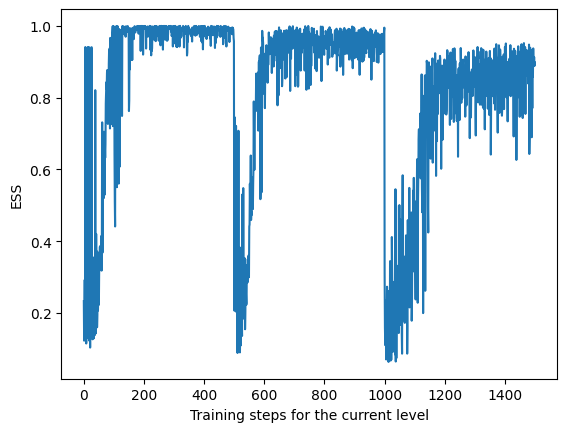

In [10]:
plt.plot(np.asarray(ESS))
plt.ylabel('ESS')
plt.xlabel('Training steps for the current level')

### In order to do the warm-restart training, the model loads weights of the previous levels (if checkpoint exists). If no weights are available train a new model from scratch. 

In [11]:
'''if os.path.exists(res_paths['weights'] and res_paths['dict_hist']):
    print(f'\n============================================================================================================================\n')
    print(f"Loading model {res_paths['weights']}.")
    print(f'\n============================================================================================================================\n')
    load(model, optimizer, res_paths['weights'])
    with open(res_paths['dict_hist'], 'rb') as handle:
        history= pickle.load(handle)
    print(f'\n============================================================================================================================\n')
    print(f"Loading successful!")
    print(f'\n============================================================================================================================\n')

else:
    print(f'\n============================================================================================================================\n')
    print(f"Nothing to load. Training of new model... ")
    print(f'\n============================================================================================================================\n')

    history=model.train(nepochs, bs, lr, print_freq, h_path, flex_kernel=True, on_file=True)
    save(model, optimizer, res_paths['weights'])
    write(history, lc_path)

    print(f'\n============================================================================================================================\n')
    print(f"Training successful!")
    print(f'\n============================================================================================================================\n')
'''

'if os.path.exists(res_paths[\'weights\'] and res_paths[\'dict_hist\']):\n    print(f\'\n============================================================================================================================\n\')\n    print(f"Loading model {res_paths[\'weights\']}.")\n    print(f\'\n============================================================================================================================\n\')\n    load(model, optimizer, res_paths[\'weights\'])\n    with open(res_paths[\'dict_hist\'], \'rb\') as handle:\n        history= pickle.load(handle)\n    print(f\'\n============================================================================================================================\n\')\n    print(f"Loading successful!")\n    print(f\'\n============================================================================================================================\n\')\n\nelse:\n    print(f\'\n==============================================================================

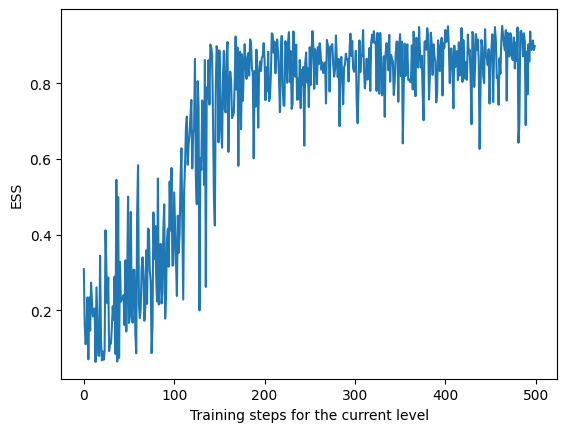

In [12]:
bins = 10 # binning to plot training history.

if history:
    plt.plot(np.asarray(history['ESS']))
    plt.ylabel('ESS')
    plt.xlabel('Training steps for the current level')

-------------
-------------
# Analysis: Reverse Metrics
This sections includes metrics which require samples from the model, e.g., $s\sim q_\theta$ where $q_\theta$ is the autoregressive neural network.
The resulting script `res_paths['sim']` will store:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`

In [13]:
model.eval()
w,E,m,t = model.sample_n_OBS(100,1000)

In [14]:
gamma_analysis(w, res_paths['sim']) # Stores data: Loss, FreeEn, ESS_rev
_=gamma_analysis_OBS(E, w, res_paths['sim']) # Stores data: Internal Energy
_=gamma_analysis_OBS(np.abs(m), w, res_paths['sim']) # Stores data: Absolute magnetization
print(f"Results saved at: {res_paths['sim']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measures.log


-------------
-------------
# Analysis: Forward metrics
> Note to user:
> - This only works for small lattices. As this is just a demo, configurations for larger lattices (or different $\beta$) are not provided and users have to generate reference configurations by themselves. Once configurations are available the pipeline below can be used.
> - Ensure to unzip the configurations before running the code below.


This sections includes metrics which require samples from the true distribution, e.g., $s\sim p$ where $p$ is the target Boltzmann distribution.
Such samples can be obtained with standard methods such as the Cluster method. For the sake of this demo, configs sampled with cluster method are stored in `data/config/Ising_data_nx16_beta0.4400000000_data1000000.dat`.

The script `res_paths['sim_md']` will store:

`Loss_rev, FreeEn_rev, ESS_rev, Loss_fwd, FreeEn_fwd, ESS_fwd, mode_dropping_est,  InternalEn, Absmag`

The script `res_paths['cluster']` will store analysis performed on samples from Cluster method, i.e., $s\sim p$:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`


In [15]:
ndat = 1000000
path_ising = main_path + f'config/Ising_data_nx{model.Lf}_beta0.4400000000_data{ndat}.dat'

In [16]:
file_exists_or_unzip(path_ising,main_path + f'config')

✅ File '../data/config/Ising_data_nx8_beta0.4400000000_data1000000.dat' found. Continuing...


In [17]:
# Loads data for 16x16
# N.B. This might take some time.
data = np.genfromtxt(path_ising).reshape(-1, Lf, Lf)

In [18]:
cluster_analysis(data, ising_energy, beta, res_paths['cluster']) # U, tau |m|, tau |m|
print(f"Results saved at: {res_paths['cluster']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measuresCluster.log


In [19]:
wf = model.sample_from_MCMC(data, 1000)

In [20]:
gamma_analysis_modedrop(w, wf, res_paths['sim_md']) # Stores data: Loss, betaF, ESS, Floss, FbetaF, FESS, modedrop, U, absmag
print(f"Results saved at: {res_paths['sim_md']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measures_modedrop.log


-------------
-------------
# Independent Metropolis-Hastings

The cells below run Neural MCMC using a Metropolis Hastings accept-reject steps to unbias the samples drawn from the model as proposed in [Nicoli et al. Phys. Rev. E (2020)](https://link.aps.org/accepted/10.1103/PhysRevE.101.023304). A cluster analysis is performed on the accepted samples and results are saved in `res_paths['mh']`.

In [21]:
model.eval()

In [22]:
ensemble=make_mcmc_ensemble(model,100, 1000,model.device)

In [23]:
print(f"Acceptance rate: {np.asarray(ensemble['accepted']).mean().item()}")

Acceptance rate: 0.773


In [24]:
cluster_analysis(np.asarray(ensemble['x']).reshape((-1, Lf, Lf) ), model.energy, model.beta, res_paths['mh']) #U, tau |m|, tau |m|
print(f"Results saved at: {res_paths['mh']}")    

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measuresIMH.log
